In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from skimage.util import montage
import os
import cv2 
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import numpy as np
import seaborn as sns

random.seed(0)

log_dir = "~/logs"
writer = SummaryWriter(log_dir)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

<font size = '6'> **Create a dataset** </font>

<font>DataSource: [UC Sandiego Covid 19 CT Scans](https://github.com/UCSD-AI4H/COVID-CT)</font>



In [17]:
!git clone https://github.com/UCSD-AI4H/COVID-CT

fatal: destination path 'COVID-CT' already exists and is not an empty directory.
Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 1 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 31.97 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


<font size = '6'>**Extract the zip files that contain COVID/Non-COVID CT scan images**</font>

In [18]:
%cd COVID-CT/Images-processed/

!unzip CT_COVID.zip 
!unzip CT_NonCOVID.zip



/content/COVID-CT/Images-processed
Archive:  CT_COVID.zip
replace CT_COVID/2020.03.01.20029769-p21-73_1%1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
replace __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
replace CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: __MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: __MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inflating: CT_COVID/2020.02.25.20021568-p24-111%8.png  
  inflating: __MACOSX/CT_COVID/._2020.02.25.20021

In [19]:
# Movie back to the COVID-19 Folder
%cd ..

/content/COVID-CT
/content/COVID-CT/COVID-CT


<font size = '6'> **COVID-19 Positive Instances**</font>

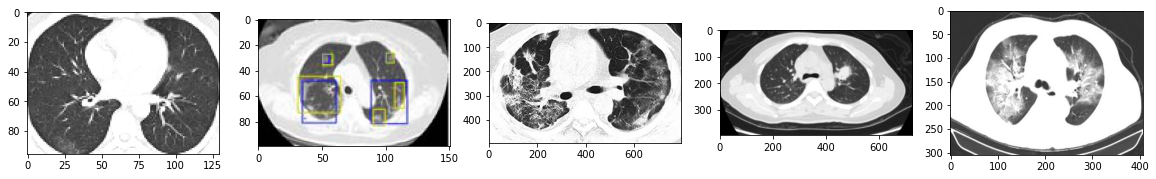

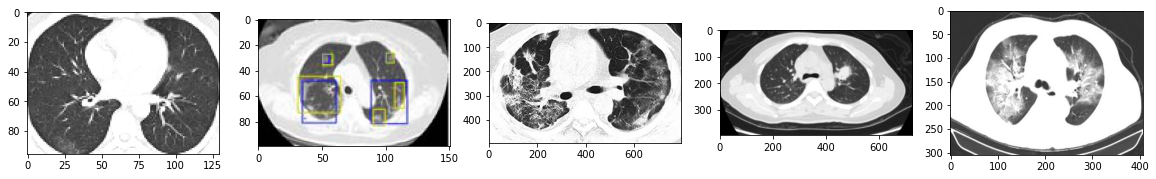

In [20]:
covid_files_path = 'Images-processed/CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

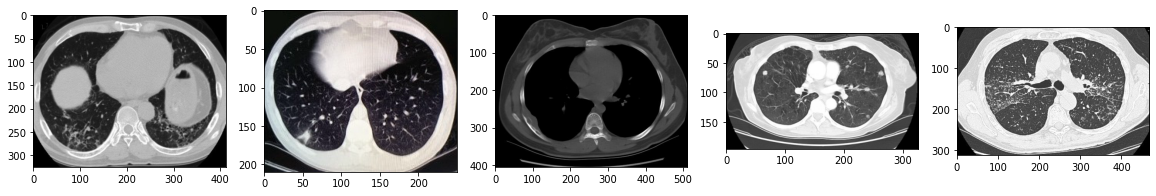

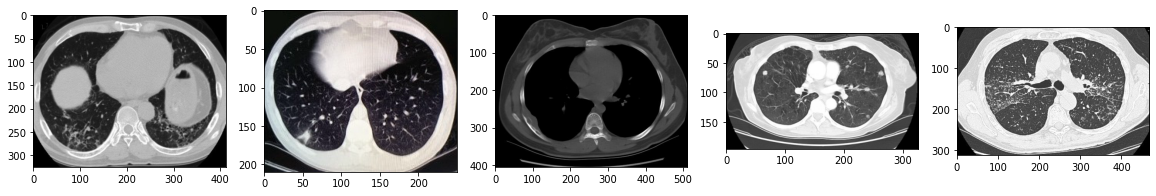

In [21]:
covid_files_path = 'Images-processed/CT_NonCOVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [22]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [23]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

In [24]:
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [25]:
batchsize = 8

trainset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [26]:
def compute_metrics(model, test_loader, plot_roc_curve = False):
    
    model.eval()
    
    val_loss = 0
    val_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()
    path_list    = []

    
    for iter_num, data in enumerate(test_loader):
        
        # Convert image data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)
        
        # Compute the loss
        with torch.no_grad():
            output = model(image)
        
        # Log loss
        val_loss += criterion(output, target.long()).item()

        
        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
        # Bookkeeping 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()])
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                  target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                  output_dict= True)
    
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    
    # accuracy
    accuracy = classification_metrics['accuracy']
    
    # confusion matrix
    conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
    
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
    
    # plot the roc curve
    if plot_roc_curve:
        fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    
    # put together values
    metrics_dict = {"Accuracy": accuracy,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": conf_matrix,
                    "Validation Loss": val_loss / len(test_loader),
                    "score_list":  score_list.tolist(),
                    "pred_list": pred_list.tolist(),
                    "target_list": target_list.tolist(),
                    "paths": path_list}
    
    
    return metrics_dict

In [27]:
model = vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [28]:
learning_rate = 0.01
optimizer     = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)


In [29]:
from collections import deque

class EarlyStopping(object):
    def __init__(self, patience = 8):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.previous_loss = int(1e8)
        self.previous_accuracy = 0
        self.init = False
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
        self.best_running_accuracy = 0
        self.best_running_loss = int(1e7)
    
    def add_data(self, model, loss, accuracy):
        
        # compute moving average
        if not self.init:
            running_loss = loss
            running_accuracy = accuracy 
            self.init = True
        
        else:
            running_loss = 0.2 * loss + 0.8 * self.previous_loss
            running_accuracy = 0.2 * accuracy + 0.8 * self.previous_accuracy
        
        # check if running accuracy has improved beyond the best running accuracy recorded so far
        if running_accuracy < self.best_running_accuracy:
            self.accuracy_decrease_iters += 1
        else:
            self.best_running_accuracy = running_accuracy
            self.accuracy_decrease_iters = 0
        
        # check if the running loss has decreased from the best running loss recorded so far
        if running_loss > self.best_running_loss:
            self.loss_increase_iters += 1
        else:
            self.best_running_loss = running_loss
            self.loss_increase_iters = 0
        
        # log the current accuracy and loss
        self.previous_accuracy = running_accuracy
        self.previous_loss = running_loss        
        
    
    def stop(self):
        
        # compute thresholds
        accuracy_threshold = self.accuracy_decrease_iters > self.patience
        loss_threshold = self.loss_increase_iters > self.patience
        
        
        # return codes corresponding to exhuaustion of patience for either accuracy or loss 
        # or both of them
        if accuracy_threshold and loss_threshold:
            return 1
        
        if accuracy_threshold:
            return 2
        
        if loss_threshold:
            return 3
        
        
        return 0
    
    def reset(self):
        # reset
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
    
early_stopper = EarlyStopping(patience = 5)

In [ ]:
best_model = model
best_val_score = 0

criterion = nn.CrossEntropyLoss()

# The more epoch we train, the higher accuracy the model will predict
for epoch in range(1):

    model.train()    
    train_loss = 0
    train_correct = 0
    
    for iter_num, data in enumerate(train_loader):
        print(iter_num)
        image, target = data['img'].to(device), data['label'].to(device)     

        # Compute the loss
        output = model(image)
        loss = criterion(output, target.long()) / 8
        
        # Log loss
        train_loss += loss.item()
        loss.backward()

        # Perform gradient udpate
        if iter_num % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
            

        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
    
    # Compute and print the performance metrics
    metrics_dict = compute_metrics(model, val_loader)
    print('------------------ Epoch {} Iteration {}--------------------------------------'.format(epoch,
                                                                                                 iter_num))
    print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
    print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
    print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
    print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
    print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
    print("------------------------------------------------------------------------------")
    
    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_val_score:
        torch.save(model, "best_model.pkl")
        best_val_score = metrics_dict['Accuracy']
    
    
    # print the metrics for training data for the epoch
    print('\nTraining Performance Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    # log the accuracy and losses in tensorboard
    writer.add_scalars( "Losses", {'Train loss': train_loss / len(train_loader), 'Validation_loss': metrics_dict["Validation Loss"]},
                                   epoch)
    writer.add_scalars( "Accuracies", {"Train Accuracy": 100.0 * train_correct / len(train_loader.dataset),
                                       "Valid Accuracy": 100.0 * metrics_dict["Accuracy"]}, epoch)

    # Add data to the EarlyStopper object
    early_stopper.add_data(model, metrics_dict['Validation Loss'], metrics_dict['Accuracy'])
    
    # If both accuracy and loss are not improving, stop the training
    if early_stopper.stop() == 1:
        break
    
    # if only loss is not improving, lower the learning rate
    if early_stopper.stop() == 3:
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [40]:
model = torch.load('best_model.pkl')

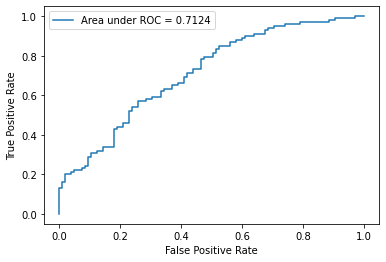

------------------- Test Performance --------------------------------------
Accuracy 	 0.586
Sensitivity 	 0.224
Specificity 	 0.924
Area Under ROC 	 0.712
------------------------------------------------------------------------------


In [41]:
model = torch.load("best_model.pkl" )

metrics_dict = compute_metrics(model, test_loader, plot_roc_curve = True)
print('------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
print("------------------------------------------------------------------------------")

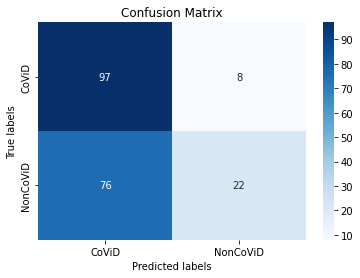

In [42]:
conf_matrix = metrics_dict["Confusion Matrix"]
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);